# Offline heat budget over the broader location of the cruise. 
Use 2010 output to explore budget and debug offline calculations.

In [1]:
#Packages
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
from datetime import datetime

import glob
from xhistogram.xarray import histogram
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.ticker as tick
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.dates as mdates
import pandas as pd
from matplotlib.ticker import AutoMinorLocator

land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                edgecolor='face',
                                facecolor=cfeature.COLORS['land'])

states_provinces = cfeature.NaturalEarthFeature(
                   category='cultural',
                   name='admin_1_states_provinces_lines',
                   scale='10m',
                   facecolor='none')
crs = ccrs.PlateCarree(central_longitude=-92.5)

In [2]:
# path = glob.glob('/d1/shared/TXLA_ROMS/nesting/2022/nest/ocean_dia_child_*.nc') No tracer diagnostics, keep a copy for my records
tslice = slice('2010-06-10','2010-06-16')
path = glob.glob('/d1/shared/TXLA_ROMS/numerical_mixing/nest/ver0/ocean_dia_child_0000*.nc') # We do have them for 2010
ds = xr.open_mfdataset(path, chunks = {'ocean_time':1})
ds = ds.sel(ocean_time=tslice)

path1 = glob.glob('/d1/shared/TXLA_ROMS/numerical_mixing/nest/ver0/ocean_avg_child_*.nc')
dsa = xroms.open_mfnetcdf(path1, chunks = {'ocean_time':1})
dsa, grida = xroms.roms_dataset(dsa, Vtransform = 2)
dsa = dsa.sel(ocean_time=tslice)

# model_time = str(datetime(2022,7,3,0,0))

# The temperature equation $T$ may be written as 
#### $\frac{\partial T}{\partial t}+ \textbf{u} \cdot \nabla T =\nabla_H \cdot (\kappa_H \nabla_H T)+  \frac{\partial}{\partial z} \left(\kappa_T {\frac{\partial T}{\partial z}} \right)$,
with vertical boundary conditions 
#### $\kappa_T  \left(\frac{\partial T}{\partial z}\right)=\frac{Q_T}{\rho_0 C_p}$ @ $z=\eta$ ,
#### $\kappa_T  \left(\frac{\partial T}{\partial z}\right)=0$ @ $z=-h$.
After volume-integrating over a control volume extending from the ocean bottom to the sea surface, we have 
#### $\iiint \partial_t T \, dV + \iint (\mathbf{u}T) \cdot \hat{n} \, dA = \frac{Q_T}{\rho_0 C_p}$. 
<br>

> Locally, the terms have units of degrees C per second. 
> - $Q_T$ is the surface net heat flux [W/m$^2$].
> - $\rho_0$ is the mean seawater density [kg/m$^3$].
> - $C_p$ is the specific heat of seawater [J/kg/deg C].

# First, we construct a volume-integrated heat budget with diagnostic files, then do it offline 

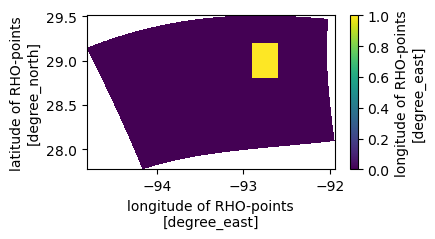

In [3]:
# Box for the location of the cruise
lon = np.array([-92.9,-92.6])
lat = np.array([28.8,29.2])
box = ((lon[0] < ds.lon_rho) & (ds.lon_rho < lon[1]) & (lat[0] < ds.lat_rho) & (ds.lat_rho < lat[1])).compute()

fig = plt.figure(figsize=(4,2))
box.plot(x='lon_rho',y='lat_rho')

In [64]:
dTdt = (ds.temp_rate*dsa.dV).where(box).sel(ocean_time=tslice).sum(['eta_rho','xi_rho','s_rho']).load()
hadv = (ds.temp_hadv*dsa.dV).where(box).sel(ocean_time=tslice).sum(['eta_rho','xi_rho','s_rho']).load()
vadv = (ds.temp_vadv*dsa.dV).where(box).sel(ocean_time=tslice).sum(['eta_rho','xi_rho','s_rho']).load()
T_adv = hadv+vadv
hdiff = (ds.temp_hdiff*dsa.dV).where(box).sel(ocean_time=tslice).sum(['eta_rho','xi_rho','s_rho']).load()
vdiff = (ds.temp_vdiff*dsa.dV).where(box).sel(ocean_time=tslice).sum(['eta_rho','xi_rho','s_rho']).load()
diffusion = hdiff+vdiff

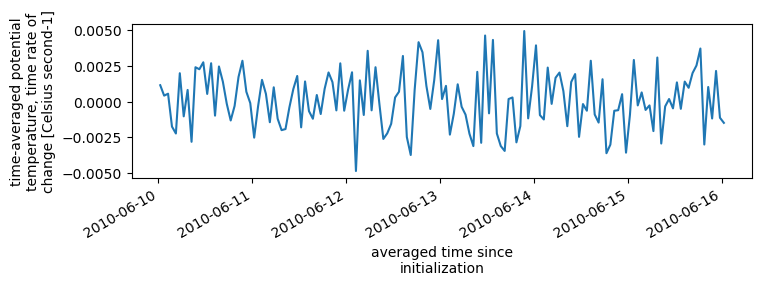

In [65]:
res = (dTdt-T_adv)-diffusion
res.plot(figsize=(8,2))

# The residual is nill, good to go 

In [73]:
dTdt.name = 'dTdt'
hadv.name = 'hadv'
vadv.name = 'vadv'
T_adv.name = 'T_adv'
hdiff.name = 'hdiff'
vdiff.name = 'vdiff'
diffusion.name = 'diffusion'
ds_test = xr.merge([dTdt,hadv,vadv,T_adv,hdiff,vdiff,diffusion])
ds_test.to_netcdf('heat_budget_june_2010.nc')

In [5]:
ds_test = xr.open_dataset('heat_budget_june_2010.nc')

## Plot the results 

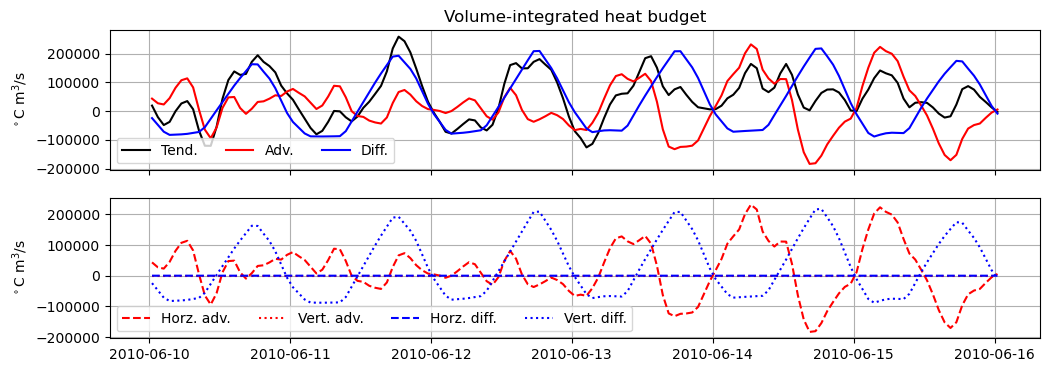

In [6]:
fig, ax = plt.subplots(2,1, figsize = (12,4))

ax[0].plot(ds_test.dTdt.ocean_time, ds_test.dTdt, label = 'Tend.', lw = 1.5, c = 'k')
ax[0].plot(ds_test.dTdt.ocean_time, ds_test.T_adv, label = 'Adv.', lw = 1.5, c = 'r')
ax[0].plot(ds_test.dTdt.ocean_time, ds_test.diffusion, label = 'Diff.', lw = 1.5, c = 'b')
ax[0].set_xticklabels('')
ax[0].set_title('Volume-integrated heat budget')
ax[1].plot(ds_test.dTdt.ocean_time, ds_test.hadv, label = 'Horz. adv.', lw = 1.5, c = 'r', ls = '--')
ax[1].plot(ds_test.dTdt.ocean_time, ds_test.vadv, label = 'Vert. adv.', lw = 1.5, c = 'r', ls = ':')
ax[1].plot(ds_test.dTdt.ocean_time, ds_test.hdiff, label = 'Horz. diff.', lw = 1.5, c = 'b', ls = '--')
ax[1].plot(ds_test.dTdt.ocean_time, ds_test.vdiff, label = 'Vert. diff.', lw = 1.5, c = 'b', ls = ':')

for i in range(2):
    ax[i].grid(which='both')
    ax[i].legend(loc='best', ncol = 4)
    ax[i].set_ylabel(r'$^\circ$C m$^3$/s')
    
# plt.savefig('vint_heat_budget_june_2010_child.jpg', dpi=300)

In [8]:
print('Bulk horz/total adv [%]', ds_test.hadv.sum().values/(ds_test.T_adv.sum().values)*100)
print('Bulk horz/total diff [%]', ds_test.hdiff.sum().values/(ds_test.diffusion.sum().values)*100)

Bulk horz/total adv [%] 100.00000036341056
Bulk horz/total diff [%] 0.043738213541609644


The budget is balanced as expected. While tendency peaks in magnitude, there is a clear diurnal heating component that drives the vertical boundary condition at the sea surface. Lateral difffusion is negligble, so is vertical advection

# Construct the volume-averaged heat budget 

In [78]:
V = dsa.dV.where(box).sel(ocean_time=tslice).sum(['eta_rho','xi_rho','s_rho']).load()

dTdt_vavg = dTdt/V
hadv_vavg = hadv/V
vadv_vavg = vadv/V
T_adv_vavg = T_adv/V
hdiff_vavg = hdiff/V
vdiff_vavg = vdiff/V
diffusion_vavg = diffusion/V

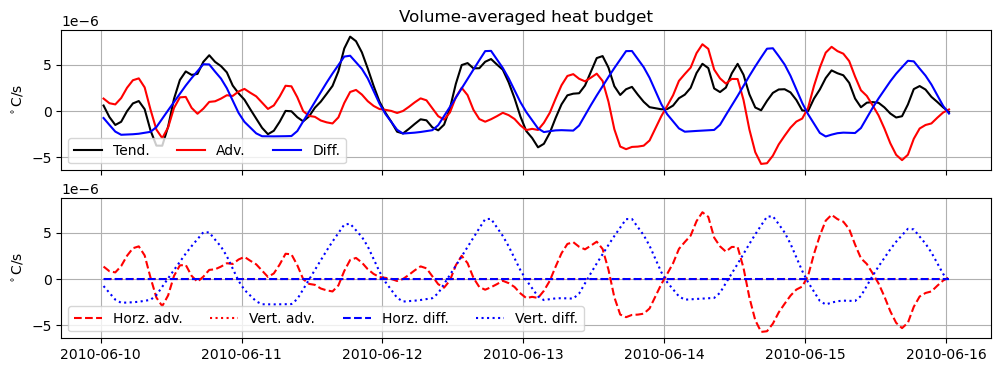

In [87]:
fig, ax = plt.subplots(2,1, figsize = (12,4), sharey=True)

ax[0].plot(dTdt.ocean_time, dTdt_vavg, label = 'Tend.', lw = 1.5, c = 'k')
ax[0].plot(dTdt.ocean_time, T_adv_vavg, label = 'Adv.', lw = 1.5, c = 'r')
ax[0].plot(dTdt.ocean_time, diffusion_vavg, label = 'Diff.', lw = 1.5, c = 'b')
ax[0].set_xticklabels('')
ax[0].set_title('Volume-averaged heat budget')
ax[1].plot(dTdt.ocean_time, hadv_vavg, label = 'Horz. adv.', lw = 1.5, c = 'r', ls = '--')
ax[1].plot(dTdt.ocean_time, vadv_vavg, label = 'Vert. adv.', lw = 1.5, c = 'r', ls = ':')
ax[1].plot(dTdt.ocean_time, hdiff_vavg, label = 'Horz. diff.', lw = 1.5, c = 'b', ls = '--')
ax[1].plot(dTdt.ocean_time, vdiff_vavg, label = 'Vert. diff.', lw = 1.5, c = 'b', ls = ':')

for i in range(2):
    ax[i].grid(which='both')
    ax[i].legend(loc='best', ncol = 4)
    ax[i].set_ylabel(r'$^\circ$C/s')

### Now repeat, but vertically average over the top 1 m to the sea surface 

In [24]:
dTdt = ((ds.temp_rate).where((dsa.z_rho)>-1).where(box)).sel(ocean_time=tslice).mean(['eta_rho','xi_rho','s_rho']).load()
hadv = ((ds.temp_hadv).where(dsa.z_rho>-1).where(box)).sel(ocean_time=tslice).mean(['eta_rho','xi_rho','s_rho']).load()
vadv = ((ds.temp_vadv).where(dsa.z_rho>-1).where(box)).sel(ocean_time=tslice).mean(['eta_rho','xi_rho','s_rho']).load()
T_adv = hadv+vadv
hdiff = ((ds.temp_hdiff).where(dsa.z_rho>-1).where(box)).sel(ocean_time=tslice).mean(['eta_rho','xi_rho','s_rho']).load()
vdiff = ((ds.temp_vdiff).where(dsa.z_rho>-1).where(box)).sel(ocean_time=tslice).mean(['eta_rho','xi_rho','s_rho']).load()
diffusion = hdiff+vdiff
         
dTdt.name = 'dTdt'
hadv.name = 'hadv'
vadv.name = 'vadv'
T_adv.name = 'T_adv'
hdiff.name = 'hdiff'
vdiff.name = 'vdiff'
diffusion.name = 'diffusion'
ds_test = xr.merge([dTdt,hadv,vadv,T_adv,hdiff,vdiff,diffusion])
ds_test.to_netcdf('heat_budget_june_2010_top1m_avg.nc')

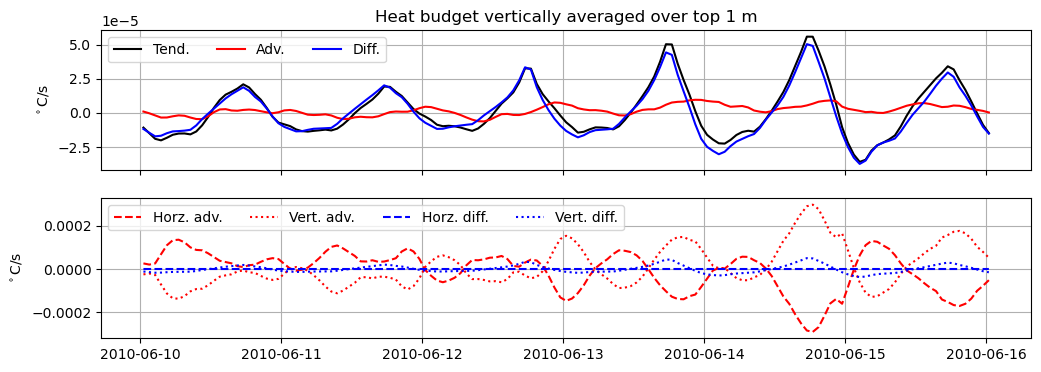

In [9]:
ds_test = xr.open_dataset('heat_budget_june_2010_top1m_avg.nc')

fig, ax = plt.subplots(2,1, figsize = (12,4))
ax[0].plot(ds_test.dTdt.ocean_time, ds_test.dTdt, label = 'Tend.', lw = 1.5, c = 'k')
ax[0].plot(ds_test.dTdt.ocean_time, ds_test.T_adv, label = 'Adv.', lw = 1.5, c = 'r')
ax[0].plot(ds_test.dTdt.ocean_time, ds_test.diffusion, label = 'Diff.', lw = 1.5, c = 'b')
ax[0].set_xticklabels('')
ax[0].set_title('Heat budget vertically averaged over top 1 m')
ax[1].plot(ds_test.dTdt.ocean_time, ds_test.hadv, label = 'Horz. adv.', lw = 1.5, c = 'r', ls = '--')
ax[1].plot(ds_test.dTdt.ocean_time, ds_test.vadv, label = 'Vert. adv.', lw = 1.5, c = 'r', ls = ':')
ax[1].plot(ds_test.dTdt.ocean_time, ds_test.hdiff, label = 'Horz. diff.', lw = 1.5, c = 'b', ls = '--')
ax[1].plot(ds_test.dTdt.ocean_time, ds_test.vdiff, label = 'Vert. diff.', lw = 1.5, c = 'b', ls = ':')

for i in range(2):
    ax[i].grid(which='both')
    ax[i].legend(loc='best', ncol = 4)
    ax[i].set_ylabel(r'$^\circ$C/s')

# To conclude, we can do the calculations efficiently for a control volume of this size, but lack the means to do it offline. 